In [12]:
import fasttext

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np


In [2]:
torch.cuda.is_available()

True

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=2048, num_layers=2, dropout=0.1, offset=256):
        super().__init__()

        # build a list of dims: [input_dim, hidden_dim, hidden_dim-offset, ...]
        dims = [input_dim]
        for _ in range(num_layers):
            dims.append(dims[-1] == input_dim and hidden_dim or max(dims[-1] - offset, offset))

        layers = []
        for in_dim, out_dim in zip(dims, dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))

        # final sigmoid head
        layers.append(nn.Linear(dims[-1], 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).view(-1)

In [8]:
# This is what typically the mapper is according to the MUSE paper
class Generator(nn.Module):
    def __init__(self, embedding_dimension):
        super(Generator, self).__init__()
        self.dimension = embedding_dimension
        self.model = nn.Sequential(nn.Linear(self.dimension, self.dimension), nn.ReLU())

    def forward(self, x):
        return self.model(x)

In [25]:
## Assume that we have a src embedding and target embeddings

def train(src_emb, tar_emb, generator, discriminator, num_epochs, config):
    # src_emb and tar_emb are the torch.Embeddings

    optimizer_for_discriminator = torch.optim.Adam(discriminator.parameters(), lr=config["discriminator_lr"]) 
    optimizer_for_generator = torch.optim.Adam(generator.parameters(), lr=config["generator_lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    src_emb = src_emb.to(device)
    tar_emb = tar_emb.to(device)

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Lists to store loss values
    discriminator_losses = []
    generator_losses = []

    for i in range(num_epochs):

        # Lets update the discriminator multiple times rather than once in a epoch

        for discr_steps in range(config["discriminator_train_steps"]):

            discriminator.train()

            # Sampling with replacement

            src_idx = torch.randint(0, src_emb.num_embeddings, (config["batch_size"],), device=device)
            tar_idx = torch.randint(0, tar_emb.num_embeddings, (config["batch_size"],), device=device)

            src_word_batch_embeddings = src_emb(src_idx.to(device))
            tar_word_batch_embeddings = tar_emb(tar_idx.to(device))
            
            linear_transformation_of_src_embeddings = generator(src_word_batch_embeddings.to(device)).detach() # no grad calculation is needed
            
            # Let the descriminator classify the transformed embeddings
            # If the descriminator is trained only with the fake data, then it always predicts the data as fake.
            # @ discr_predictions = discriminator(linear_transformation_of_src_embeddings) 
            # So, the descriminator has to be aware of both the fake and real data

            discriminator_input = torch.cat([linear_transformation_of_src_embeddings, tar_word_batch_embeddings], dim=0)
            # print("Shape of the discriminator : ", discriminator_input.shape)
            actual_output = torch.cat([torch.zeros(config["batch_size"]), torch.ones(config["batch_size"])], dim=0) # 0 for fake/generated 1 for real
            # print("Dimension of input layer of the discriminator : ", discriminator.model[0].in_features)
            pred_output = discriminator(discriminator_input.to(device))

            optimizer_for_discriminator.zero_grad() # Avoiding gradient accumulations
            discriminator_loss = nn.BCELoss()(pred_output.to(device), actual_output.to(device))
            discriminator_loss.backward()
            optimizer_for_discriminator.step()

            discriminator_losses.append(discriminator_loss.item())

        for gen_steps in range(config["generator_train_steps"]):
            src_idx = torch.randint(0, src_emb.num_embeddings, (config["batch_size"],))
            src_words = src_emb(src_idx.to(device))
            linear_transformation = generator(src_words.to(device))

            discri_prediction = discriminator(linear_transformation.to(device))
            fake_preds = torch.ones(config["batch_size"]) # the generator should learn to fool the discriminator

            optimizer_for_generator.zero_grad()
            generator_loss = nn.BCELoss()(discri_prediction.to(device), fake_preds.to(device))

            generator_loss.backward()
            optimizer_for_generator.step()

            generator_losses.append(generator_loss.item())

        if(i%100==0):
            print(f"Epoch {i}/{num_epochs} — D loss: {discriminator_losses[-1]:.4f}, G loss: {generator_losses[-1]:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(discriminator_losses, label="Discriminator Loss", alpha=0.7)
    plt.plot(generator_losses,     label="Generator Loss",     alpha=0.7)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return generator, discriminator

In [26]:
import fasttext

model_hi_path = r"./custom_models/model_hi.bin"
model_en_path = r"./custom_models/model_en.bin"

model_hi = fasttext.load_model(model_hi_path)
model_en = fasttext.load_model(model_en_path)

In [27]:
model_hi = fasttext.train_unsupervised("./TrainingReadyHindiText.txt")
model_en = fasttext.train_unsupervised("./TrainingReadyEnglishText.txt")

Read 3M words
Number of words:  24356
Number of labels: 0
Progress: 100.0% words/sec/thread:   81461 lr:  0.000000 avg.loss:  1.851365 ETA:   0h 0m 0s avg.loss:  2.170722 ETA:   0h 0m 8s 1.950489 ETA:   0h 0m 4s
Read 4M words
Number of words:  38115
Number of labels: 0
Progress: 100.0% words/sec/thread:   55440 lr:  0.000000 avg.loss:  1.752350 ETA:   0h 0m 0s 78.8% words/sec/thread:   55649 lr:  0.010595 avg.loss:  1.721733 ETA:   0h 0m 2s


In [28]:
src_vocab = model_en.get_words()
src_embedding_matrix = np.array([model_en.get_word_vector(word) for word in src_vocab])
tar_vocab = model_hi.get_words()
tar_embedding_matrix = np.array([model_hi.get_word_vector(word) for word in tar_vocab])

src_embedding_dim = model_en.get_dimension()
tar_embedding_dim = model_hi.get_dimension()

src_embed = nn.Embedding.from_pretrained(torch.tensor(src_embedding_matrix, dtype=torch.float32))
tar_embed = nn.Embedding.from_pretrained(torch.tensor(tar_embedding_matrix, dtype=torch.float32))

print("Size of the source embedding : ", src_embed.weight.shape)

# initialize the generator and discriminator
generator = Generator(src_embedding_dim)
discriminator = Discriminator(input_dim=src_embedding_dim, hidden_dim=1024, num_layers=3, dropout=0.1, offset=256)

config = {
    "discriminator_lr":0.00001,
    "generator_lr": 0.00001,
    "discriminator_train_steps": 1,
    "generator_train_steps": 1,
    "batch_size": 10
}

Size of the source embedding :  torch.Size([38115, 100])


Epoch 0/500 — D loss: 0.6917, G loss: 0.6759
Epoch 100/500 — D loss: 0.6018, G loss: 0.7192
Epoch 200/500 — D loss: 0.3691, G loss: 0.8923
Epoch 300/500 — D loss: 0.1780, G loss: 1.4800
Epoch 400/500 — D loss: 0.0719, G loss: 2.1845


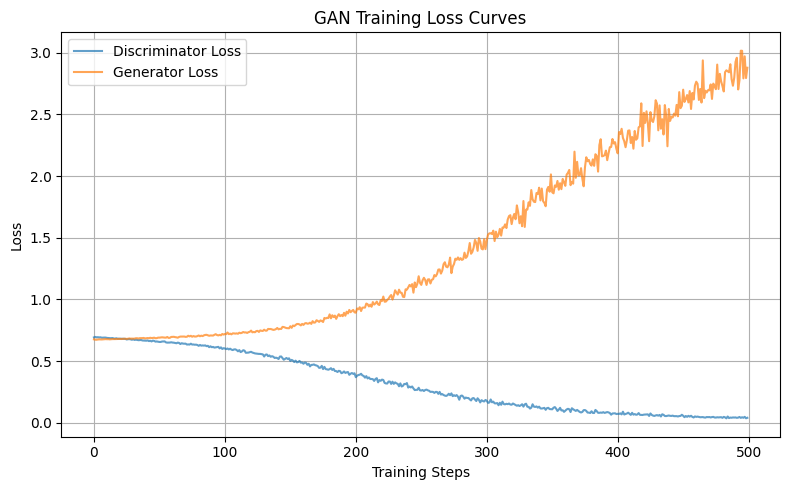

In [29]:
mapper, trained_discriminator = train(src_embed, tar_embed, generator, discriminator, num_epochs=500, config=config)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similarities(word, word_embedding, fasttext_model):
    similarities = []

    for target_word in fasttext_model.get_words():
        target_embedding = fasttext_model.get_word_vector(target_word)
        similarity = cosine_similarity([word_embedding], [target_embedding])[0][0]
        similarities.append((target_word, similarity))

    return similarities

def get_top_k_pairs(similarities, k):
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    return [word for word, _ in top_k]


def generate_pseudo_translation_pairs(mapper, word, model_en, model_hi, k):
    pseudo_bilingual_pairs = {}
    tar_word_embeddings = [model_hi.get_word_vector(word) for word in model_hi.get_words()]
    word_embedding = model_en.get_word_vector(word)
    similarities = get_similarities(word, word_embedding, model_hi)
    
    return get_top_k_pairs(similarities, k)

In [31]:
def precision(muse_dict, mapper, model_en, model_hi, k):
    correct = 0
    total = len(muse_dict)
    for (en,hi) in zip(muse_dict.keys(), muse_dict.values()):
        generated_pairs = generate_pseudo_translation_pairs(mapper, en, model_en, model_hi, k)
        if hi in generated_pairs:
            correct += 1
            
    return correct/total

In [32]:
# Loading the muse en_hi parallel corpus dictionary
def create_dict(file_path, size=5000):
    en_hi = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            en, hi = line.strip().split()
            en_hi[en] = hi
            if(len(en_hi)==size):
                break
                
    return en_hi

In [34]:
muse_translation_dict = create_dict(r"../GeneratedDatasets/muse_crosslingual_en_hi/en-hi.txt")

In [ ]:
precision(muse_translation_dict, mapper, model_en, model_hi, k=10)